# Generating Sup. figure 2

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import numpy as np
import pyranges as pr
import pybedtools as pbt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

## Importing files

In [3]:

def intersect_bed(df1, df2, invert=False, how="containment"):
    gr1, gr2 = pr.PyRanges(df1), pr.PyRanges(df2)
    gr = gr1.intersect(gr2, invert=invert, nb_cpu=6, how=how)
    return gr.df.drop_duplicates()


genes_from_annotation = pr.read_gtf("/Users/pavel/Desktop/Rise_and_SINE//mus_musculus/Mus_musculus.GRCm38.96.gtf").df
genes_from_annotation = genes_from_annotation[["gene_id", "Chromosome", "Strand", "Start", "End", "gene_name"]]
genes_from_annotation.columns = ["id", "chr", "strand", "start", "end", "name"]
genes_from_annotation["chr"] = np.array(["chr"] * len(genes_from_annotation["chr"])) + np.array(genes_from_annotation["chr"].astype(str))

# filtering out unwanted and incomplete chromosomes
genes_from_annotation = genes_from_annotation[[len(chromosome) < 6 for chromosome in genes_from_annotation['chr']]]
genes_from_annotation = genes_from_annotation[[chromosome != "chrMT" for chromosome in genes_from_annotation['chr']]]

# Importing ZGA genes
ZGA_genes_list = pd.read_csv('/Users/pavel/Desktop/Rise_and_SINE/tables/Pan_1_degree_ZGA_genes.csv')["Gene_id"].str.upper()


# Adjusting annotation and creating ZGA and non-ZGA data frames
window_before_TSS = 10000
Non_ZGA_genes_from_annotation = genes_from_annotation[~genes_from_annotation["name"].str.upper().isin(ZGA_genes_list)]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation.drop_duplicates(subset='name', keep='first')
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation[["chr", "start", "end", "strand", "name"]]
start = [x - window_before_TSS if z == "+" else y for x, y, z in zip(Non_ZGA_genes_from_annotation["start"], Non_ZGA_genes_from_annotation["end"], Non_ZGA_genes_from_annotation["strand"])]
end = [x if z == "+" else y + window_before_TSS for x, y, z in zip(Non_ZGA_genes_from_annotation["start"], Non_ZGA_genes_from_annotation["end"], Non_ZGA_genes_from_annotation["strand"])]
Non_ZGA_genes_from_annotation["start"] = start
Non_ZGA_genes_from_annotation["end"] = end
Non_ZGA_genes_from_annotation.columns = [0,1,2,3,4]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation[[0,1,2,4]]
Non_ZGA_genes_from_annotation.columns = ["Chromosome", "Start", "End", "name"]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation.sample(frac = 1)

ZGA_genes_from_annotation = genes_from_annotation[genes_from_annotation["name"].str.upper().isin(ZGA_genes_list)]
ZGA_genes_from_annotation = ZGA_genes_from_annotation.drop_duplicates(subset='name', keep='first')
ZGA_genes_from_annotation = ZGA_genes_from_annotation[["chr", "start", "end", "strand", "name"]]
start = [x - window_before_TSS if z == "+" else y for x, y, z in zip(ZGA_genes_from_annotation["start"], ZGA_genes_from_annotation["end"], ZGA_genes_from_annotation["strand"])]
end = [x if z == "+" else y + window_before_TSS for x, y, z in zip(ZGA_genes_from_annotation["start"], ZGA_genes_from_annotation["end"], ZGA_genes_from_annotation["strand"])]
ZGA_genes_from_annotation["start"] = start
ZGA_genes_from_annotation["end"] = end
ZGA_genes_from_annotation.columns = [0,1,2,3,4]
ZGA_genes_from_annotation = ZGA_genes_from_annotation[[0,1,2,4]]
ZGA_genes_from_annotation.columns = ["Chromosome", "Start", "End", "name"]
ZGA_genes_from_annotation = ZGA_genes_from_annotation.sample(frac = 1)


In [6]:
data = pd.read_csv("/Volumes/pool-totipotency/Pavel/VIENNE/RNAseq_Proteomics/DEgenes_2cell-vs-G2zygote.csv", sep=",") 
data["external_gene_name"] = data["gene_id"].str.upper()
Expression = data

In [7]:
all_genes_from_annotation = pd.concat([ZGA_genes_from_annotation, Non_ZGA_genes_from_annotation]) #[["Chromosome", "Start", "End"]]
all_genes_from_annotation.Start = [int(x) for x in all_genes_from_annotation.Start]
all_genes_from_annotation.End = [int(x) for x in all_genes_from_annotation.End]
all_genes_from_annotation["name"] = ["ZGA" if x else "non-ZGA" for x in all_genes_from_annotation["name"].str.upper().isin(ZGA_genes_from_annotation.name.str.upper())]

In [10]:
condition_2C = "/Volumes/pool-totipotency/Pavel/VIENNE/ATAC_review_2cell/atac_2c_DMSO_mm10_wk90.128_merged_sort.spikeNorm.bedgraph"
condition_2c_raw = pd.read_csv(condition_2C, header=None, sep="\t",index_col=None) 
condition_2c_raw.columns = ["Chromosome", "Start", "End", 3]
condition_2c_raw_G_pbt = pbt.BedTool.from_dataframe(condition_2c_raw)

In [11]:
df_intersect_omniATAC_2cell = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_annotation), condition_2c_raw_G_pbt, loj=True).to_dataframe()
df_intersect_omniATAC_2cell["thickStart"].replace('.',np.nan, inplace=True)
df_intersect_omniATAC_2cell = df_intersect_omniATAC_2cell.dropna()
df_intersect_omniATAC_2cell["thickStart"] = df_intersect_omniATAC_2cell["thickStart"].apply(pd.to_numeric)
df_intersect_omniATAC_2cell = df_intersect_omniATAC_2cell.groupby(['chrom', 'start', 'end', 'name']).agg({'thickStart': np.sum}).reset_index()

/opt/miniconda3/envs/py37/lib/python3.8/site-packages/pybedtools/bedtool.py:3714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pandas.read_csv(self.fn, *args, sep="\t", **kwargs)


In [12]:
mm10_hc_rep = pd.read_csv('/Volumes/pool-totipotency/Pavel/VIENNE/SINE/MOUSE_ATAC_SEQ/UCSC_repeatmasker.bed',sep="\t")
mm10_hc_rep = mm10_hc_rep[["genoName","genoStart","genoEnd","strand","repName","repClass","repFamily"]]
mm10_hc_rep = mm10_hc_rep.drop_duplicates()
mm10_hc_rep = mm10_hc_rep[[True if len(x)<6 else False for x in list(mm10_hc_rep["genoName"])]]
mm10_hc_rep

,genoName,genoStart,genoEnd,strand,repName,repClass,repFamily
0,chr1,67108752,67108881,+,RLTR17B_Mm,LTR,ERVK
1,chr1,134217651,134217732,-,BC1_Mm,scRNA,scRNA
2,chr1,8386825,8389555,-,Lx2,LINE,L1
3,chr1,16776988,16779051,+,L1_Mus1,LINE,L1
4,chr1,33554408,33554640,-,B4,SINE,B4
...,...,...,...,...,...,...,...
5138231,chr19,61330640,61330789,-,MLT1A0,LTR,ERVL-MaLR
5138232,chr19,61330995,61331153,+,RSINE1,SINE,B4
5138233,chr19,61331174,61331210,+,AT_rich,Low_complexity,Low_complexity
5138234,chr19,61331243,61331276,-,MT-int,LTR,ERVL-MaLR


## Accessibility vs RE number

Alu
Slope: [0.76942416]
Intercept: 0.09199204635215268
Root mean squared error:  0.024976858021288146
R2 score:  0.2913285301084344
B2
Slope: [0.54089925]
Intercept: 0.09444687045853206
Root mean squared error:  0.02601179438942585
R2 score:  0.15969540417792372
L1
Slope: [-0.42413411]
Intercept: 0.23678234943185297
Root mean squared error:  0.03555661303127364
R2 score:  0.07924214074413571
[<matplotlib.collections.PathCollection object at 0x2a36fd4f0>, <matplotlib.collections.PathCollection object at 0x2a3706520>]
ERVL
Slope: [0.10356129]
Intercept: 0.063377696326644
Root mean squared error:  0.019052247632437066
R2 score:  0.009473327120810504
ERVK
Slope: [-0.04603676]
Intercept: 0.0666200694252146
Root mean squared error:  0.009116037579468774
R2 score:  0.003936928189343103
ERV1
Slope: [-0.00068466]
Intercept: 0.04802888658398471
Root mean squared error:  0.014894184483858826
R2 score:  5.351427115884988e-07
[<matplotlib.collections.PathCollection object at 0x3125ac310>, <matplotl

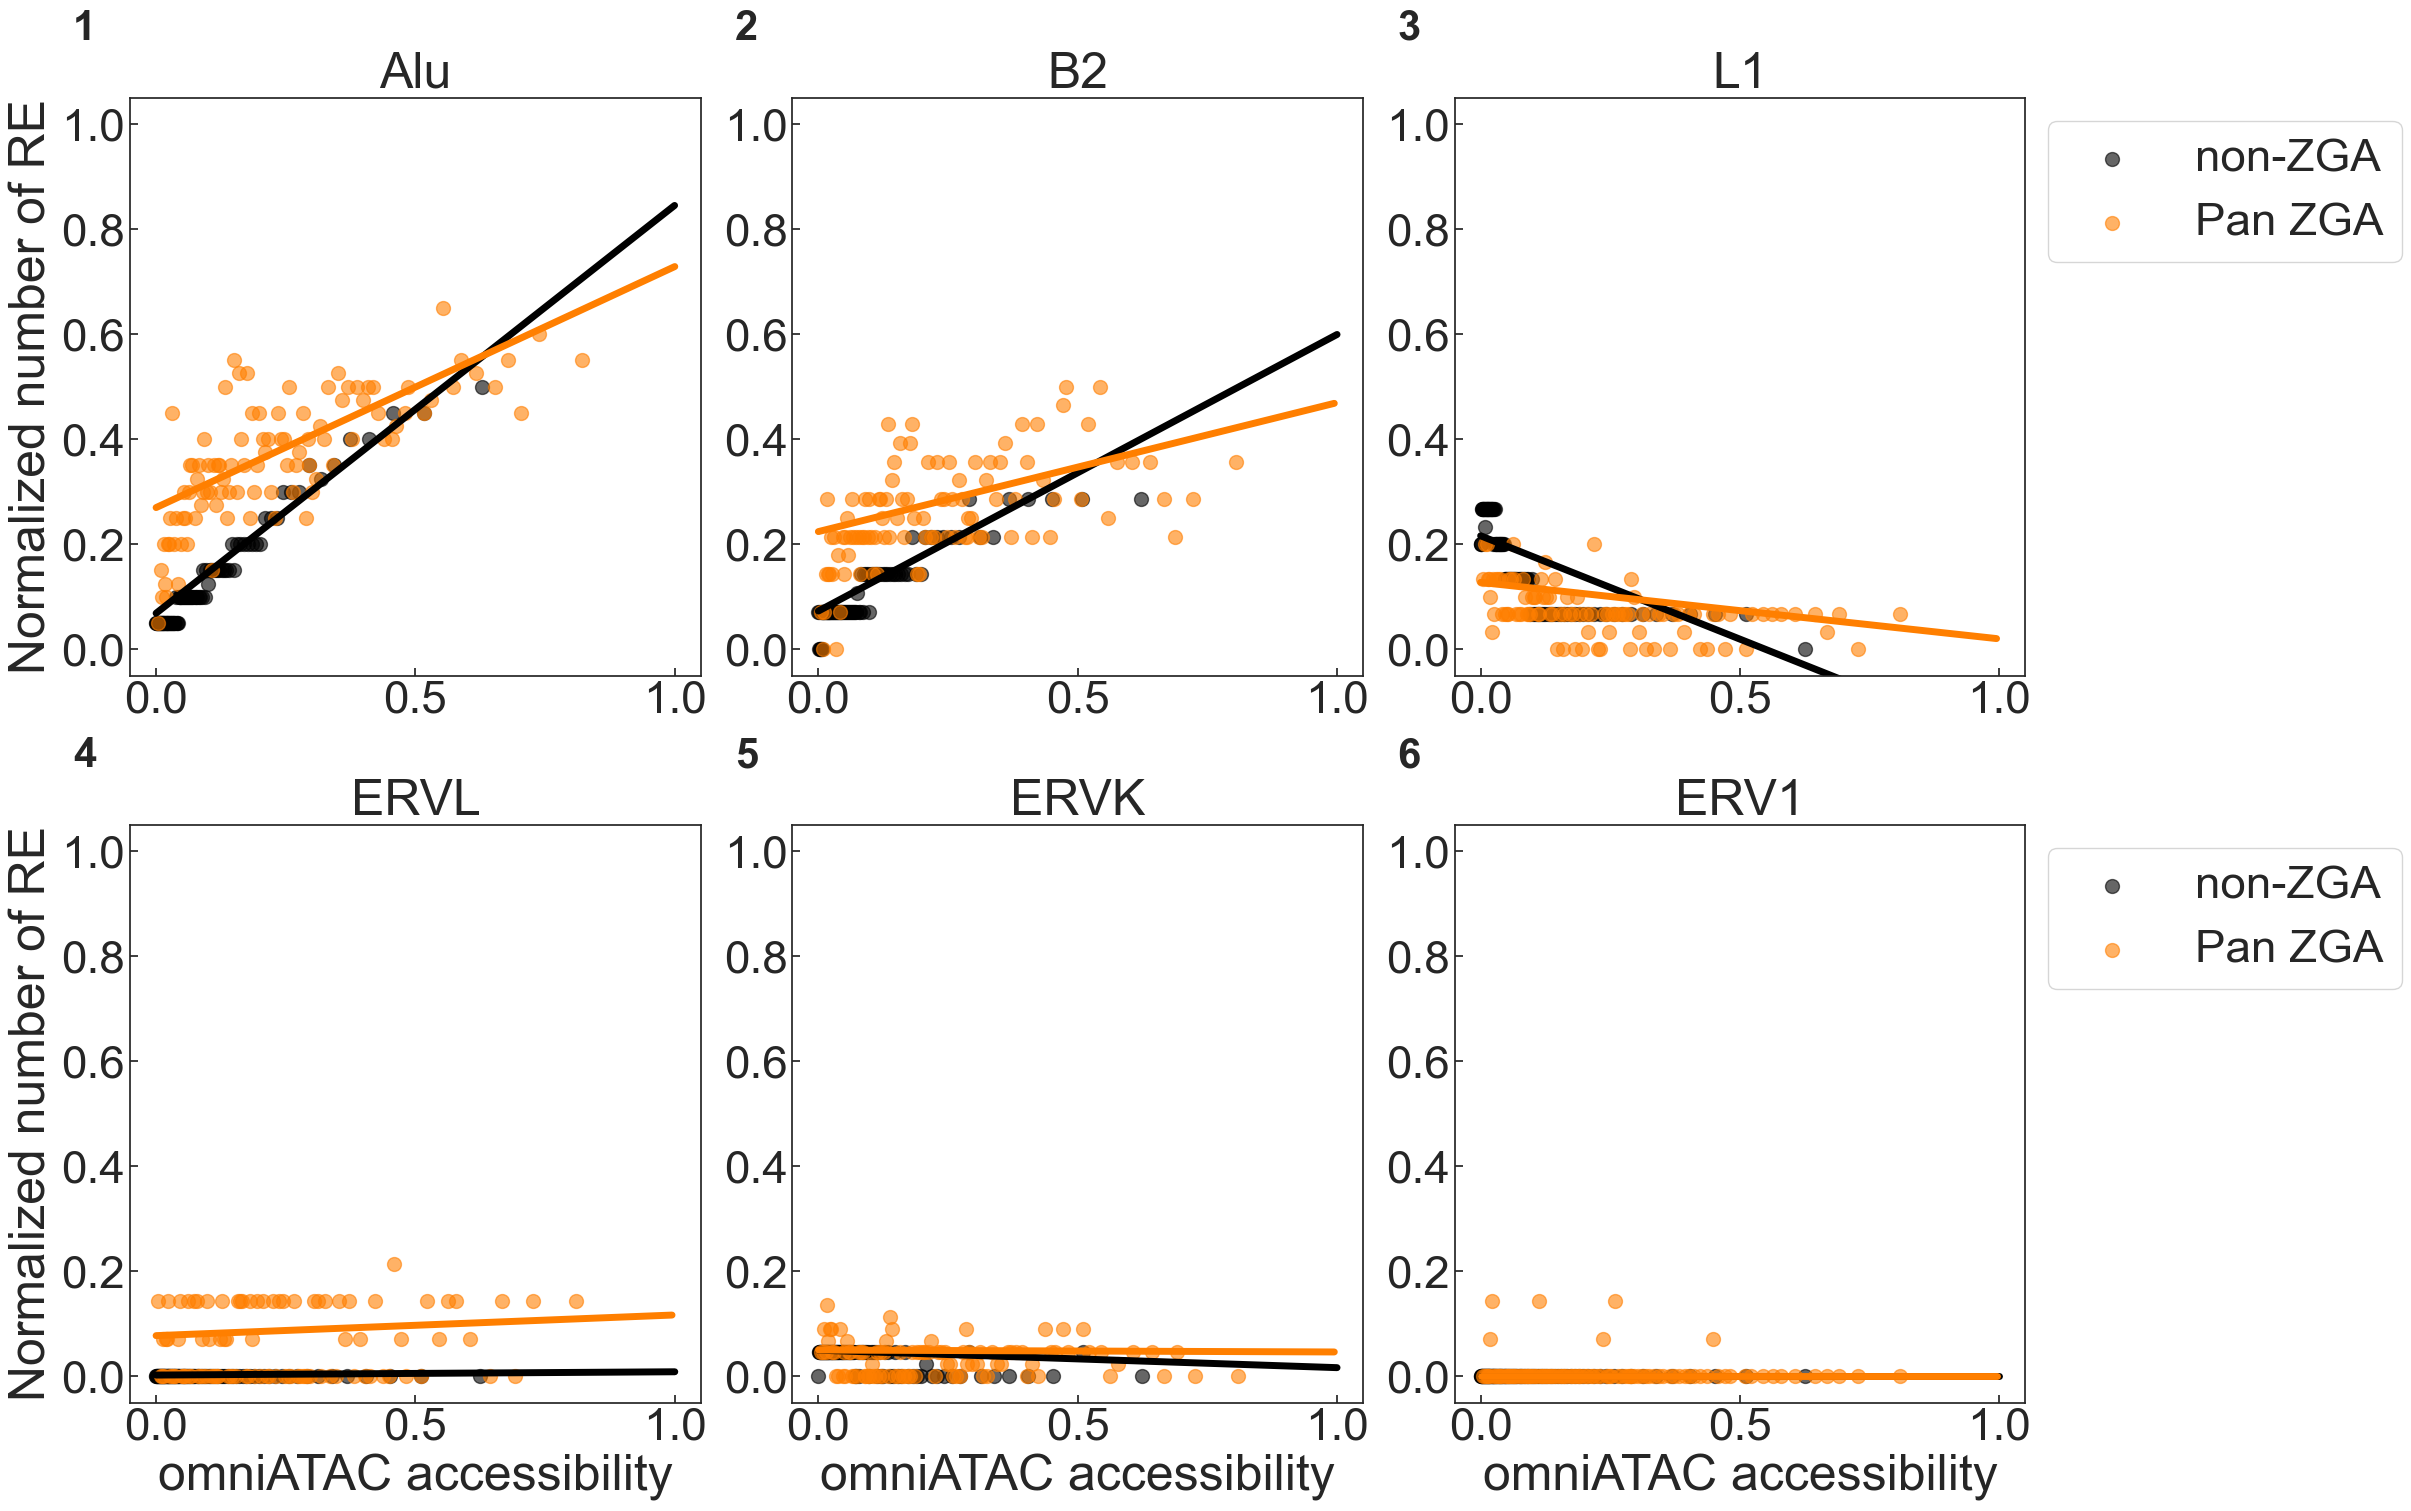

In [21]:
sns.set(font_scale=3, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'
matplotlib.rcParams['figure.figsize'] = 24, 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

f = plt.figure(constrained_layout=True)
gs = f.add_gridspec(2, 3)

i = 0
j = 0
c = 0


for region_name in ["Alu", "B2", "L1", "ERVL", "ERVK", "ERV1"]:

    print(region_name)

    header = f"{region_name}"

    mm10_hc_rep_tmp = mm10_hc_rep[mm10_hc_rep["repFamily"]==region_name]
    mm10_hc_rep_tmp = mm10_hc_rep_tmp[["genoName","genoStart","genoEnd"]]
    mm10_hc_rep_tmp = pbt.BedTool.from_dataframe(mm10_hc_rep_tmp)

    new_df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(df_intersect_omniATAC_2cell), mm10_hc_rep_tmp, c=True).to_dataframe()

    new_df["thickStart_y"] = new_df["strand"]/ mm10_hc_rep[mm10_hc_rep["repFamily"]==region_name].shape[0]
    new_df["thickStart_x"] = new_df["score"]

    new_df = new_df[new_df["thickStart_y"] < np.percentile(new_df["thickStart_y"], 99.9)]
    new_df = new_df[new_df["thickStart_x"] < np.percentile(new_df["thickStart_x"], 99.9)]

    
    new_df["thickStart_y"] = (new_df["thickStart_y"]-min(new_df["thickStart_y"]))/(max(new_df["thickStart_y"])-min(new_df["thickStart_y"]))
    new_df["thickStart_x"] = (new_df["thickStart_x"]-min(new_df["thickStart_x"]))/(max(new_df["thickStart_x"])-min(new_df["thickStart_x"]))

    y  = new_df["thickStart_y"]
    x  = new_df["thickStart_x"]



    #sns.scatterplot(data=new_df, x="thickStart_x", y="thickStart_y")
    window = int(round(len(x)*0.001, 1))
    window = len(x)//100 + 1

    dfq = pd.DataFrame({"x":np.array(x), "y":np.array(y)})
    dfq = dfq.sort_values("x")
    dfq = dfq.dropna()
    #dfq = dfq[dfq["x"] < 100]

    x = np.array([dfq["x"]]).reshape(-1, 1)
    y = np.array(dfq["y"])

    # imports

    # sckit-learn implementation

    # Model initialization
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(x, y)
    # Predict
    y_predicted = regression_model.predict(x)

    # model evaluation
    rmse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)

    # printing values
    print('Slope:' ,regression_model.coef_)
    sr = stats.spearmanr(x, y)
    if regression_model.coef_ >= 0:
        sr = sr
    else:
        sr = sr

    print('Intercept:', regression_model.intercept_)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    
    if c == 0:
        ax = f.add_subplot(gs[j,i])
    else:
        ax = f.add_subplot(gs[j,i], sharex=ax, sharey=ax)


    sns.regplot(data=new_df[new_df["name"] == "non-ZGA"],x="thickStart_x", y="thickStart_y", x_estimator=np.median, n_boot=100, robust=True, 
                scatter_kws={"color": "black", "alpha":0.6, "s": 100}, 
                line_kws={"color": "black", 'linewidth':5}, 
                ci = None, x_ci='ci',x_bins=100, label=["non-ZGA","ZGA"])

    sns.regplot(data=new_df[new_df["name"] == "ZGA"],x="thickStart_x", y="thickStart_y", x_estimator=np.median, n_boot=100, robust=True, 
                scatter_kws={"color": '#ff7f00', "alpha":0.6, "s": 100}, 
                line_kws={"color": '#ff7f00', 'linewidth':5}, 
                ci = None, x_ci='ci',x_bins=100, label=["non-ZGA","ZGA"])

    plt.title(header)
    plt.xlabel('')
    if j == 1:
        plt.xlabel('omniATAC accessibility')
    plt.ylabel('')
    if i == 0:
        plt.ylabel('Normalized number of RE')

    plt.ylim(-0.05,1.05)
    plt.xlim(-0.05,1.05)
    
    
    ax.text(-0.1, 1.1, c+1, transform=ax.transAxes, size=30, weight='bold')
    
    i += 1
    c += 1
    

    if c%3 == 0:
        handles, labels = ax.get_legend_handles_labels()
        print(handles)
        plt.legend(handles=handles, labels=["non-ZGA","Pan ZGA"], loc = 2, bbox_to_anchor = (1,1))
        j += 1
        i = 0

plt.show()

f.savefig("./figures/Oniatac_vs_REn_mod.pdf") 

In [22]:
data = pd.read_csv("/Volumes/pool-totipotency/Pavel/VIENNE/shared_with_Pavel/c88/peaks/macs2/narrow/C88_merged_macs2_peaks.narrowPeak", header=None, sep="\t",index_col=None) 
data = data.dropna()
data = data.dropna()
data_peaks = data[[0,1,2,4]]
data_peaks.columns = ["Chromosome", "Start", "End", "Score"]
data_peaks = data_peaks.drop_duplicates()
data_peaks = data_peaks[[True if len(x)<6 else False for x in list(data_peaks["Chromosome"])]]
data_peaks = pbt.BedTool.from_dataframe(data_peaks)
data_peaks

C88_merged_macs2_peaks = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_annotation), data_peaks, loj=True).to_dataframe()
C88_merged_macs2_peaks["thickStart"].replace('.',np.nan, inplace=True)
C88_merged_macs2_peaks = C88_merged_macs2_peaks.dropna()
C88_merged_macs2_peaks["thickStart"] = C88_merged_macs2_peaks["thickStart"].apply(pd.to_numeric)
C88_merged_macs2_peaks = C88_merged_macs2_peaks.groupby(['chrom', 'start', 'end', 'name']).agg({'thickStart': np.sum}).reset_index()
C88_merged_macs2_peaks


,chrom,start,end,name,thickStart
0,chr1,3063252,3073252,non-ZGA,-1
1,chr1,3092015,3102015,non-ZGA,-1
2,chr1,3242756,3252756,non-ZGA,-1
3,chr1,3368549,3378549,non-ZGA,-1
4,chr1,3377788,3387788,non-ZGA,-1
...,...,...,...,...,...
55283,chrY,90743056,90753056,non-ZGA,-1
55284,chrY,90754821,90764821,non-ZGA,-1
55285,chrY,90774737,90784737,non-ZGA,-1
55286,chrY,90827412,90837412,non-ZGA,-1


Alu
Slope: [0.44326895]
Intercept: 0.21288042435693233
Root mean squared error:  0.05097175862701454
R2 score:  0.03459305640566912
B2
Slope: [0.2944849]
Intercept: 0.1951146878714003
Root mean squared error:  0.049421236333372406
R2 score:  0.016518541107143903
L1
Slope: [-0.15114515]
Intercept: 0.25264396881189216
Root mean squared error:  0.06100615006651006
R2 score:  0.003724285806107064
[<matplotlib.collections.PathCollection object at 0x177569be0>, <matplotlib.collections.PathCollection object at 0x17756d2e0>]
ERVL
Slope: [0.11053833]
Intercept: 0.11627836509164245
Root mean squared error:  0.044007811219001575
R2 score:  0.0026862191066394647
ERVK
Slope: [-0.01664927]
Intercept: 0.1379689825713175
Root mean squared error:  0.03747193876251269
R2 score:  7.29732059634447e-05
ERV1
Slope: [0.03641341]
Intercept: 0.08748909130711847
Root mean squared error:  0.04487730175962855
R2 score:  0.0002892752406407073
[<matplotlib.collections.PathCollection object at 0x1773c96a0>, <matplot

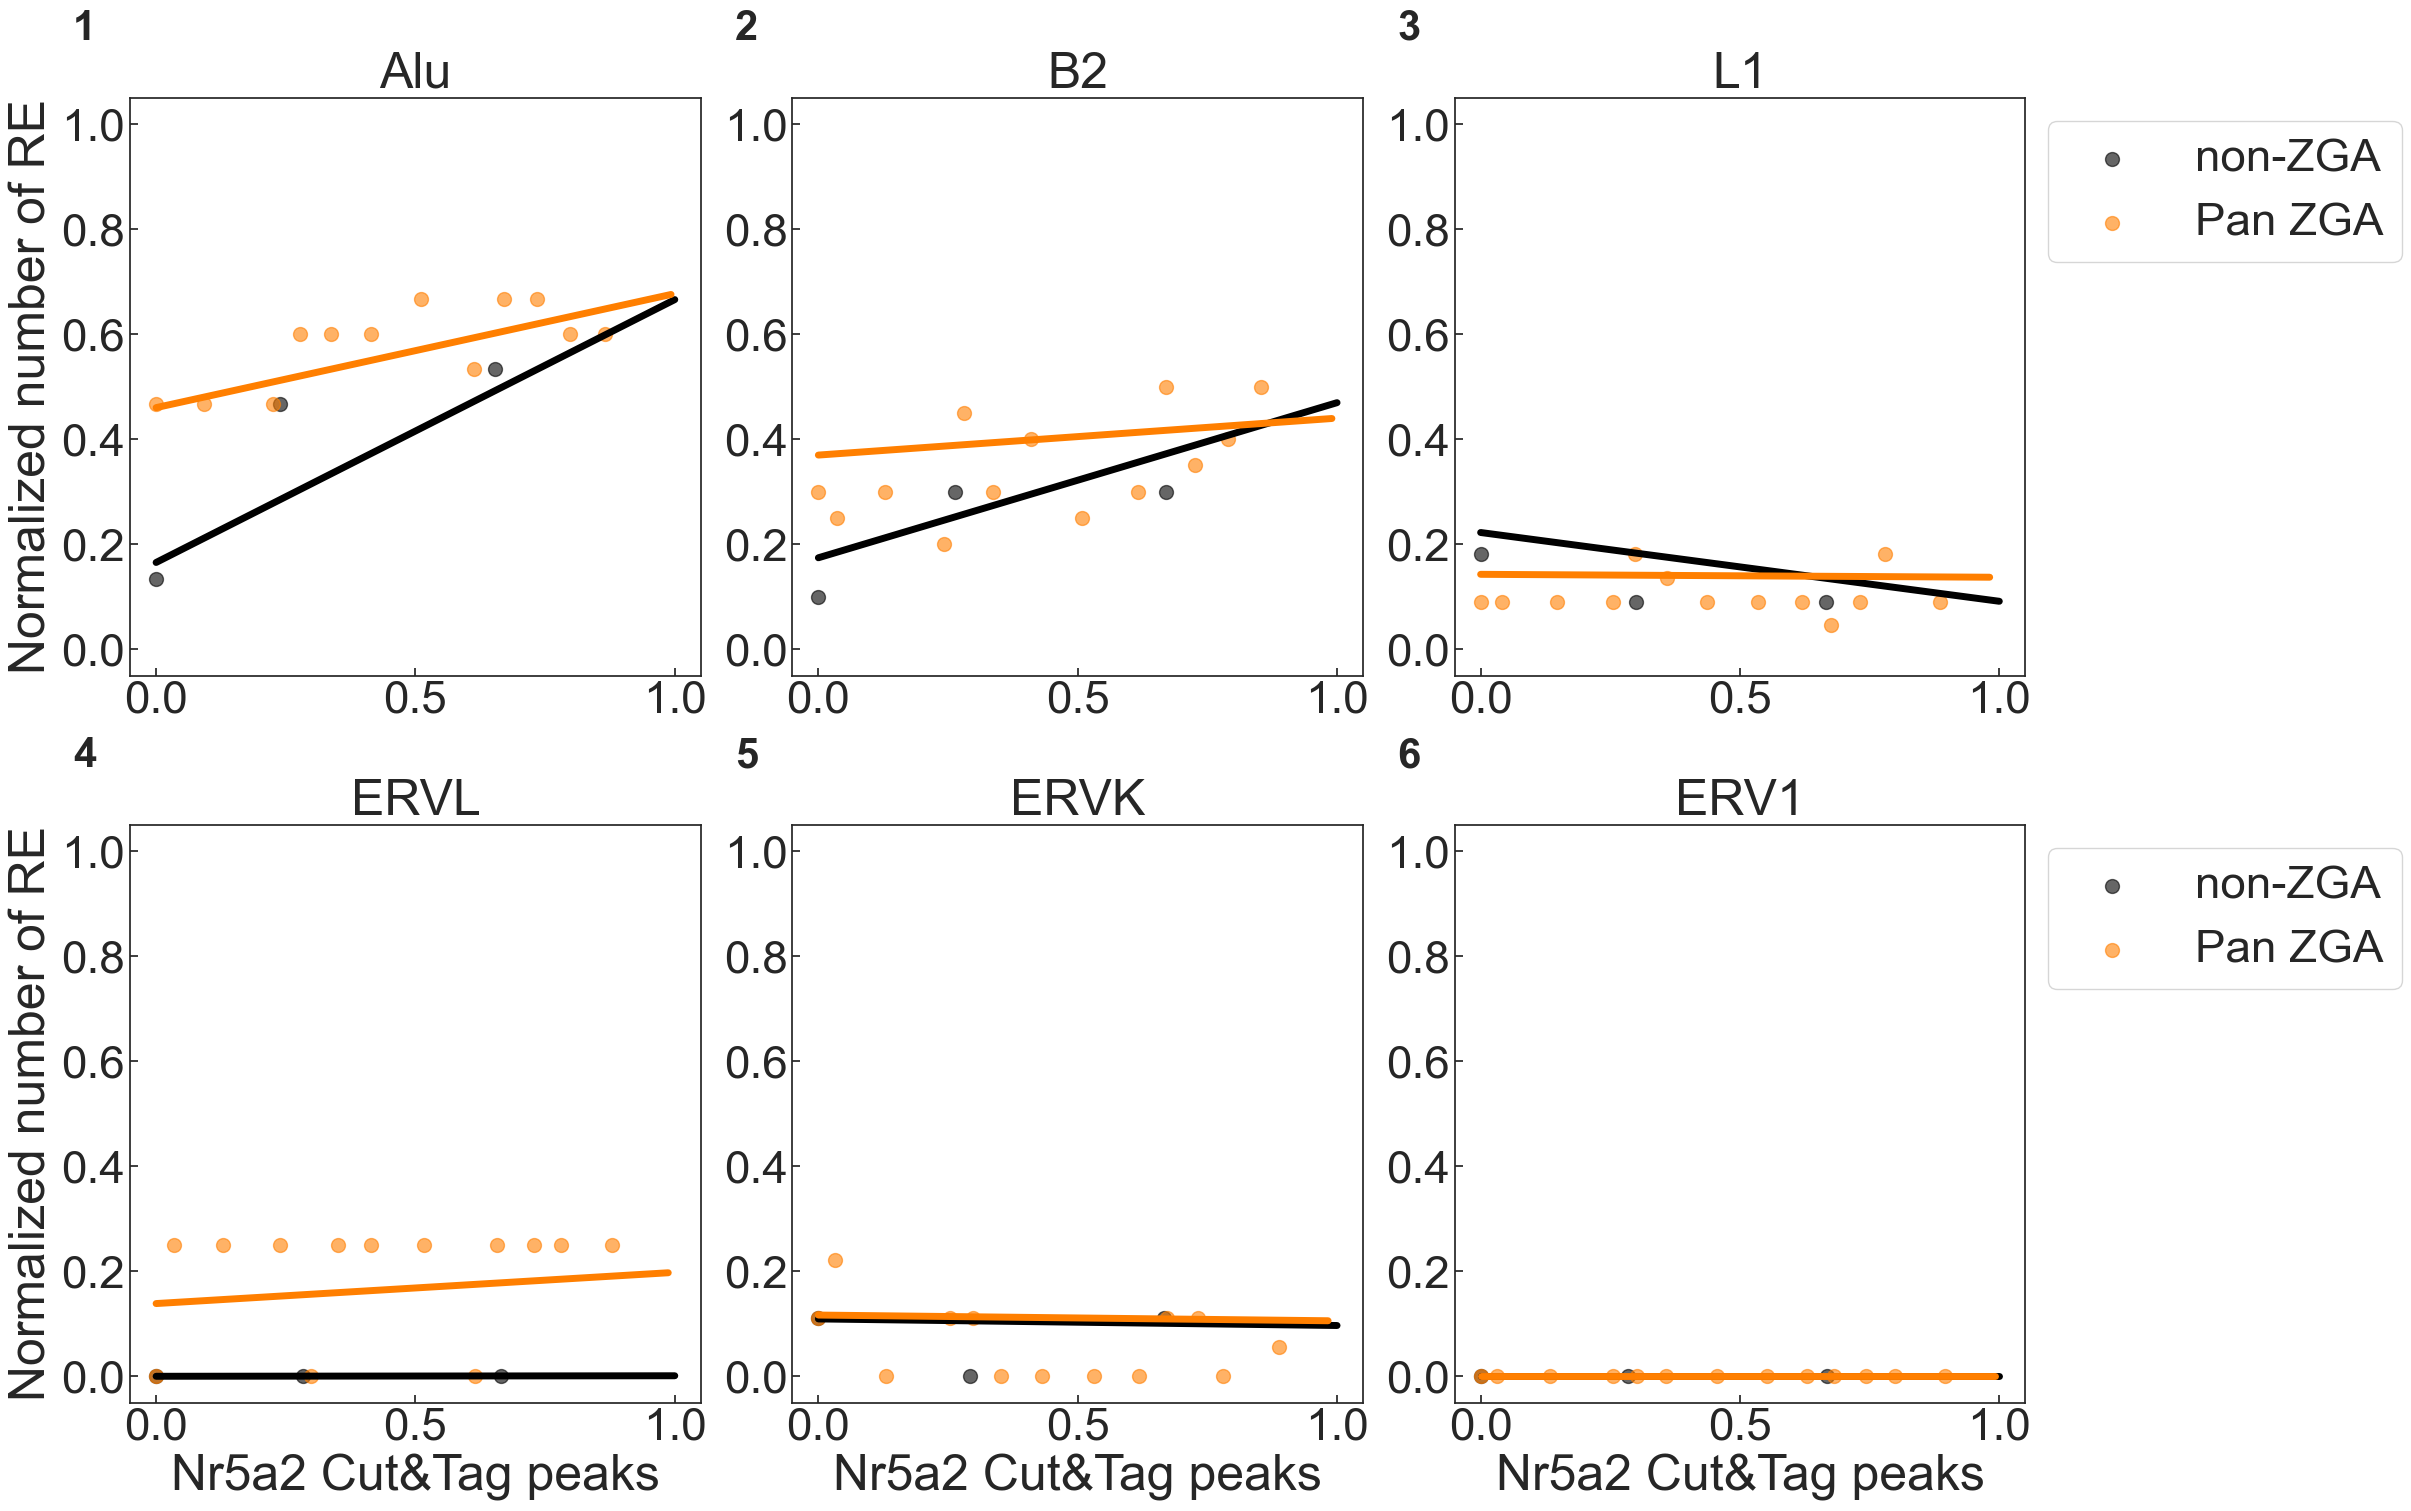

In [23]:
sns.set(font_scale=3, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'
matplotlib.rcParams['figure.figsize'] = 24, 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

f = plt.figure(constrained_layout=True)
gs = f.add_gridspec(2, 3)

i = 0
j = 0
c = 0


for region_name in ["Alu", "B2", "L1", "ERVL", "ERVK", "ERV1"]:

    print(region_name)

    header = f"{region_name}"

    mm10_hc_rep_tmp = mm10_hc_rep[mm10_hc_rep["repFamily"]==region_name]
    mm10_hc_rep_tmp = mm10_hc_rep_tmp[["genoName","genoStart","genoEnd"]]
    mm10_hc_rep_tmp = pbt.BedTool.from_dataframe(mm10_hc_rep_tmp)

    new_df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(C88_merged_macs2_peaks), mm10_hc_rep_tmp, c=True).to_dataframe()

    new_df["thickStart_y"] = new_df["strand"]/mm10_hc_rep[mm10_hc_rep["repFamily"]==region_name].shape[0]
    new_df["thickStart_x"] = new_df["score"]

    new_df = new_df[new_df["thickStart_y"] < np.percentile(new_df["thickStart_y"], 99)]
    new_df = new_df[new_df["thickStart_x"] < np.percentile(new_df["thickStart_x"], 99)]

    
    new_df["thickStart_y"] = new_df["thickStart_y"]/max(new_df["thickStart_y"])
    new_df["thickStart_x"] = new_df["thickStart_x"]/max(new_df["thickStart_x"])

    y  = new_df["thickStart_y"]
    x  = new_df["thickStart_x"]



    #sns.scatterplot(data=new_df, x="thickStart_x", y="thickStart_y")
    window = int(round(len(x)*0.001, 1))
    window = len(x)//100 + 1

    dfq = pd.DataFrame({"x":np.array(x), "y":np.array(y)})
    dfq = dfq.sort_values("x")
    dfq = dfq.dropna()
    dfq = dfq[dfq["x"] < 100]

    x = np.array([dfq["x"]]).reshape(-1, 1)
    y = np.array(dfq["y"])

    # imports

    # sckit-learn implementation

    # Model initialization
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(x, y)
    # Predict
    y_predicted = regression_model.predict(x)

    # model evaluation
    rmse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)

    # printing values
    print('Slope:' ,regression_model.coef_)
    sr = stats.spearmanr(x, y)
    if regression_model.coef_ >= 0:
        sr = sr
    else:
        sr = sr

    print('Intercept:', regression_model.intercept_)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    
    if c == 0:
        ax = f.add_subplot(gs[j,i])
    else:
        ax = f.add_subplot(gs[j,i], sharex=ax, sharey=ax)


    sns.regplot(data=new_df[new_df["name"] == "non-ZGA"],x="thickStart_x", y="thickStart_y", x_estimator=np.median, n_boot=100, robust=True, 
                scatter_kws={"color": "black", "alpha":0.6, "s": 100}, 
                line_kws={"color": "black", 'linewidth':5}, 
                ci = None, x_ci='ci',x_bins=100, label=["non-ZGA","ZGA"])

    sns.regplot(data=new_df[new_df["name"] == "ZGA"],x="thickStart_x", y="thickStart_y", x_estimator=np.median, n_boot=100, robust=True, 
                scatter_kws={"color": '#ff7f00', "alpha":0.6, "s": 100}, 
                line_kws={"color": '#ff7f00', 'linewidth':5}, 
                ci = None, x_ci='ci',x_bins=100, label=["non-ZGA","ZGA"])

    plt.title(header)
    plt.xlabel('')
    if j == 1:
        plt.xlabel('Nr5a2 Cut&Tag peaks')
    plt.ylabel('')
    if i == 0:
        plt.ylabel('Normalized number of RE')

    plt.ylim(-0.05,1.05)
    plt.xlim(-0.05,1.05)
    
    
    ax.text(-0.1, 1.1, c+1, transform=ax.transAxes, size=30, weight='bold')
    
    i += 1
    c += 1
    

    if c%3 == 0:
        handles, labels = ax.get_legend_handles_labels()
        print(handles)
        plt.legend(handles=handles, labels=["non-ZGA","Pan ZGA"], loc = 2, bbox_to_anchor = (1,1))
        j += 1
        i = 0

plt.show()


f.savefig("./figures/Nr5a2_CT_vs_REn.pdf") 


## Expression vs RE number

In [24]:
data = pd.read_csv("/Volumes/pool-totipotency/Pavel/VIENNE/RNAseq_Proteomics/DEgenes_2cell-vs-G2zygote.csv", sep=",") 
data["external_gene_name"] = data["gene_id"].str.upper()
Expression = data


data = pd.read_csv('/Volumes/pool-totipotency/Pavel/VIENNE/SINE/MOUSE_ATAC_SEQ/mm10_repeatmasker.csv',sep="\t")
mm10_hc_rep = data[["genoName","genoStart","genoEnd","strand","repName","repClass","repFamily"]].dropna()
#mm10_hc_rep = mm10_hc_rep[mm10_hc_rep["repFamily"]=="Alu"]
mm10_hc_rep = mm10_hc_rep[["genoName","genoStart","genoEnd", "strand", "repFamily"]]
mm10_hc_rep.columns = ["Chromosome", "Start", "End", "Strand", "repFamily"]
mm10_hc_rep = mm10_hc_rep.drop_duplicates()
mm10_hc_rep = mm10_hc_rep[[True if len(x)<6 else False for x in list(mm10_hc_rep["Chromosome"])]]

all_genes_from_UCSC_manual1 = pd.concat([Non_ZGA_genes_from_annotation,ZGA_genes_from_annotation])  # [["Chromosome","begin","end", "name"]]
RE_df=pd.DataFrame()
Alu = mm10_hc_rep[mm10_hc_rep["repFamily"] == "Alu"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "B1"
RE_df = RE_df.append(df)

Alu = mm10_hc_rep[mm10_hc_rep["repFamily"] == "B2"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "B2"
RE_df = RE_df.append(df)

Alu = mm10_hc_rep[mm10_hc_rep["repFamily"] == "L1"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "L1"
RE_df = RE_df.append(df)


Alu = mm10_hc_rep[mm10_hc_rep["repFamily"] == "ERVL"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "ERVL"
RE_df = RE_df.append(df)

Alu = mm10_hc_rep[mm10_hc_rep["repFamily"] == "ERVK"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "ERVK"
RE_df = RE_df.append(df)

Alu = mm10_hc_rep[mm10_hc_rep["repFamily"] == "ERV1"]
df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(all_genes_from_UCSC_manual1), pbt.BedTool.from_dataframe(Alu), c=True).to_dataframe()
df["Normalized number of RE"] = np.array(df["score"])/Alu.shape[0]

df["external_gene_name"] = df["name"].str.upper()
df["RE"] = "ERV1"
RE_df = RE_df.append(df)




RE_df_Expression = pd.merge(RE_df,Expression,on='external_gene_name')

RE_df_Expression["G2/2C log2FoldChange"] = RE_df_Expression["log2FoldChange.y"]

TF = "B1"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")
TF = "B2"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")
TF = "L1"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")

TF = "ERVL"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")

TF = "ERVK"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")

TF = "ERV1"
df = RE_df_Expression[RE_df_Expression["RE"] == TF][["Normalized number of RE", "G2/2C log2FoldChange"]].dropna()
rho, pval = stats.spearmanr(df["Normalized number of RE"], df["G2/2C log2FoldChange"])
rho, pval = round(rho,3), round(pval,3)
RE_df_Expression["RE"] = RE_df_Expression["RE"].replace(TF, f"{TF} rho:{rho} p-val:{pval}")



/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_83530/3525699241.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_83530/3525699241.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_83530/3525699241.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18gb2mcr1t_ls80000gq/T/ipykernel_83530/3525699241.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RE_df = RE_df.append(df)
/var/folders/fz/qb92b10d6d18

<Figure size 800x600 with 0 Axes>

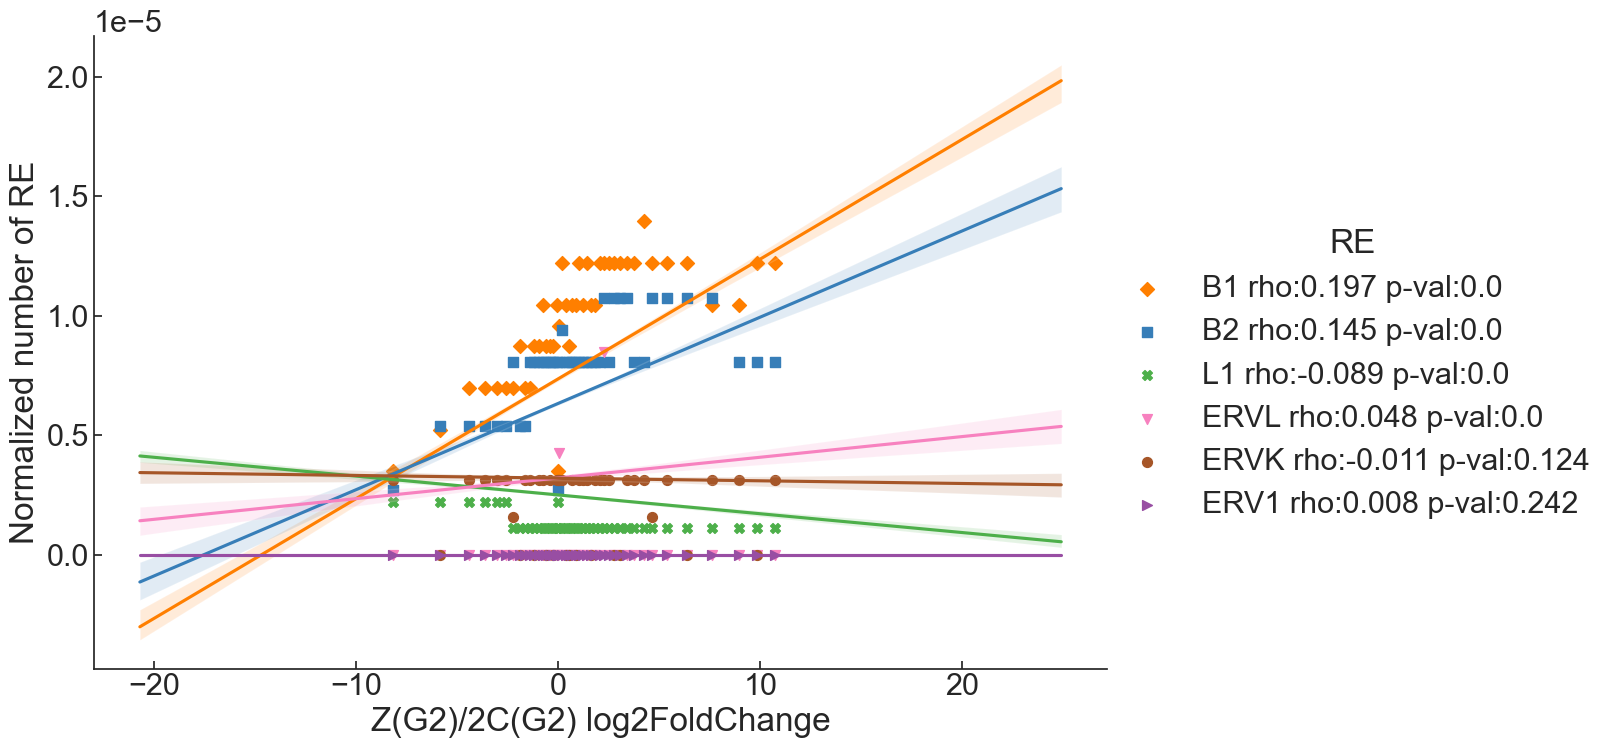

In [25]:
CB_color_cycle = ['#ff7f00', '#377eb8', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

sns.set(font_scale=2, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'
matplotlib.rcParams['figure.figsize'] = 8, 6
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

f = plt.figure(constrained_layout=True)


RE_df_Expression["Z(G2)/2C(G2) log2FoldChange"] = RE_df_Expression['G2/2C log2FoldChange']
ax = sns.lmplot(data=RE_df_Expression, x_bins=100, x_estimator=np.median, n_boot=100, robust=True, x="Z(G2)/2C(G2) log2FoldChange", y="Normalized number of RE", hue="RE", height=8, aspect=1.5, markers=["D", "s", "X", "v", "o", ">"], x_ci=None, palette=CB_color_cycle)


plt.savefig("./figures/REn_vs_Z2C_expr_FC_mod.pdf") 

